In [1]:
import os
from graspy.simulations import sbm
from graspy.plot import heatmap, pairplot, screeplot
from graspy.embed import AdjacencySpectralEmbed, LaplacianSpectralEmbed, select_dimension, selectSVD
from graspy.cluster import GaussianCluster
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from sklearn.decomposition import FastICA, NMF
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import normalize
from src.cluster import BinaryCluster
import pandas as pd
from collections import Counter
import seaborn as sns
import pandas as pd
from scipy.linalg import fractional_matrix_power
from networkx import degree_assortativity_coefficient, to_networkx_graph

#sns.set_style("white")
#sns.color_palette("deep")
#sns.set_context("talk", font_scale=1)

In [2]:
def undirect_p_2paths(ncluster, path1, path2, path1prob, path2prob):
    p1 = np.zeros([ncluster, ncluster])
    p2 = np.zeros([ncluster, ncluster])
    for i in range(len(path1)-1):
        p1[path1[i], path1[i+1]] = path1prob
        p1[path1[i+1], path1[i]] = path1prob
    for i in range(len(path2)-1):
        p2[path2[i], path2[i+1]] = path2prob
        p2[path2[i+1], path2[i]] = path2prob
    for i in range(ncluster):
        for j in range(i,ncluster):
            if i == j:
                p1[i,j] = 0.8
                p2[i,j] = 0.8
            elif p1[i,j] == 0:
                p1[i,j] = 0.1
                p1[j,i] = p1[i,j]
    for i in range(ncluster):
        for j in range(i,ncluster):
            if p2[i,j] == 0:
                p2[i,j] = 0.1
                p2[j,i] = p2[i,j]
    p = (p1 + p2) / 2
    return p, p1, p2



In [3]:
def df_embed(embed, path1, path2):
    df = pd.DataFrame(embed)
    df["block"] = 0
    df["path"] = 0
    for i in range(ncluster):
        df["block"].iloc[i*size:(i+1)*size] = i+1
        if i in path1:
            df["path"].iloc[i*size:(i+1)*size] = 1 
            if i in path2:
                df["path"].iloc[i*size:(i+1)*size] = -1 # in both paths
        elif i in path2:
            df["path"].iloc[i*size:(i+1)*size] = 2

    return df

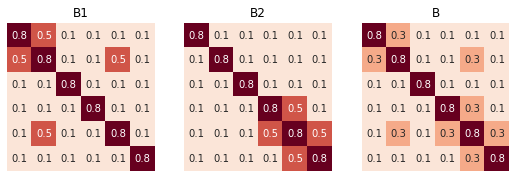

In [4]:
# generate B matrix

ncluster = 6
path1 = [0,1,4]
path2 = [3,4,5]
prob1 = 0.5; prob2 = 0.5
p,p1,p2 = undirect_p_2paths(ncluster, path1, path2, prob1, prob2)

sns.set_context()
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(9,3))
for i,j,k in zip([p1,p2,p], [ax1,ax2,ax3], ["B1","B2","B"]):
    sns.heatmap(i, annot= True, cbar=False, xticklabels="", yticklabels="", square = True, cmap = 'RdBu_r', center=0, ax = j)
    j.set_title(k)

In [5]:
# calculate assortativity coef

size = 200
n = np.repeat(size, ncluster)
G = sbm(n= n, p= p) 
g = to_networkx_graph(G)
degree_assortativity_coefficient(g)

0.3642457497711946

[Text(0, 0.5, 'Eigenvalue'),
 Text(0.5, 0, 'Component Number'),
 Text(0.5, 1.0, 'Scree Plot of B')]

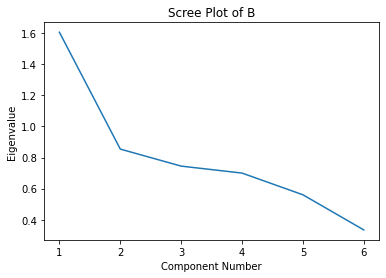

In [6]:
# scree plot

fig,ax = plt.subplots(1)
sigma = selectSVD(p, algorithm = 'full', n_components=len(p))[1]
fig = plt.plot(range(1,len(p)+1),sigma)
ax.set(xlabel = "Component Number", ylabel = "Eigenvalue", title = 'Scree Plot of B')


In [7]:
# plot pairwise embeddings

def pairplot_simple(embed_ase, embed_lse, d, method1, method2):
    #flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
    sns.set_context("talk", font_scale = 1)
    fig, axs = plt.subplots(d, d, sharex=False, sharey=False, figsize=(16, 14))
    for i in range(d):
        for j in range(d):
            ax = axs[i, j]
            if i < j:
                ax = axs[i, j]
                sns.scatterplot(data = embed_ase, x = i, y = j, ax = ax, hue = "block", style = "path", legend = False, palette= "deep")
                ax.set(xlabel='%s%i'%(method1,(i+1)), ylabel='%s%i'%(method1,(j+1)))
            elif i > j:
                ax = axs[i, j]
                sns.scatterplot(data = embed_lse, x = j, y = i, ax = ax, hue = "block", style = "path", legend = False, palette= "deep")
                ax.set(xlabel='%s%i'%(method2,(j+1)), ylabel='%s%i'%(method2,(i+1)))
                
            else:
               ax.axis("off")

    plt.tight_layout()
    return fig, axs

In [8]:
size = 200
n = np.repeat(size, ncluster)
G = sbm(n= n, p= p) 

d = 4
embed_ase = AdjacencySpectralEmbed(n_components= d).fit_transform(G)
#embed_ase = normalize(embed_ase, axis = 0) # unscaled ASE
embed_ase = df_embed(embed_ase, path1, path2)
embed_lse = LaplacianSpectralEmbed(n_components= d).fit_transform(G)
#embed_lse = normalize(embed_lse, axis = 0) # unscaled LSE
embed_lse = df_embed(embed_lse, path1, path2)
d = 3
embed_ica = FastICA(algorithm = "parallel", max_iter=1000, n_components= d, tol = 1e-5).fit_transform(G)
embed_ica = df_embed(embed_ica, path1, path2)

In [9]:
pairplot_simple(embed_ase, embed_lse, 4, 'ASE','LSE')
#plt.savefig('1⁩')
#plt.close()

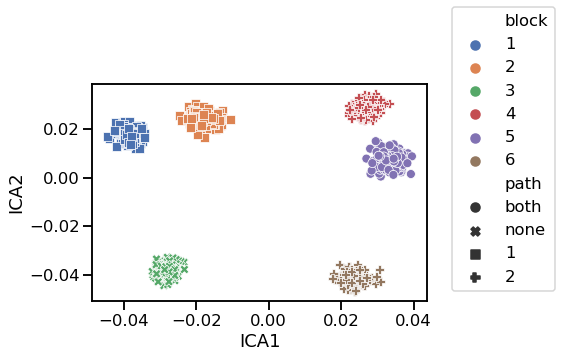

In [10]:
# plot ICA embeddings
sns.set_context("talk", font_scale = 1)
fig1, ax1 = plt.subplots(1)
#flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
fig1 = sns.scatterplot(data = embed_ica, x = 0, y = 1, hue = "block", style = "path", ax = ax1, legend='full', palette="deep")
fig1.set(xlabel = "ICA1", ylabel = "ICA2")
#fig1.legend(loc='center left', bbox_to_anchor=(1.05, 0.7), ncol=1)
a = fig1.legend(loc='center left', bbox_to_anchor=(1.05, 0.7), ncol=1).get_texts()
a[ncluster+2].set_text('both')
a[ncluster+3].set_text('none')

#stashfig("SBM-ICA-ASE-embed2paths-n=100")

In [11]:
# plot high dim ICA

fig, axs = plt.subplots(d, d, sharex=False, sharey=False, figsize=(14, 12))
for i in range(d):
    for j in range(d):
        ax = axs[i, j]
        if i < j:
            ax = axs[i, j]
            sns.scatterplot(data = embed_ica, x = i, y = j, ax = ax, hue = "block", style = "path", legend = False, palette= "deep")
            ax.set(xlabel='ICA%i'%(i+1), ylabel='ICA%i'%(j+1))
            
        else:
            ax.axis("off")

plt.tight_layout()

In [ ]:
# clustering

In [12]:
def true_label(ncluster, size):
    label_true = []
    for i in range(ncluster):
        label_true = np.concatenate((label_true, np.ones(size)+i))
    return label_true

def true_label_path(ncluster, size, path1, path2):
    label_true = np.zeros(ncluster * size)
    for i in range(len(path1)):
        label_true[path1[i] * size : (path1[i]+1) * size] = 1
    for i in range(len(path2)):
        label_true[path2[i] * size : (path2[i]+1) * size] = 2
    
    return label_true

def ARI(labels):
    score = adjusted_rand_score(label_true, labels)

    return score

In [13]:
def Kmean_cluster(size, ite):
    score_ase = np.zeros(ite); score_ica = np.zeros(ite); score_lse = np.zeros(ite)
    score = np.zeros((3,2))
    n = np.repeat(size, ncluster)
    for i in range(ite):
        G = sbm(n= n, p= p) 
        ase = AdjacencySpectralEmbed(n_components= d)
        embed_ase = ase.fit_transform(G)
        score_ase[i] = ARI(KMeans(n_clusters= ncluster).fit(embed_ase).labels_)
        ica = FastICA(algorithm = "parallel", max_iter=1000, n_components= d)
        embed_ica = ica.fit_transform(G)
        score_ica[i] = ARI(KMeans(n_clusters= ncluster).fit(embed_ica).labels_)
        lse = LaplacianSpectralEmbed(n_components= d)
        embed_lse = lse.fit_transform(G)
        score_lse[i] = ARI(KMeans(n_clusters= ncluster).fit(embed_nmf).labels_)
    method = [score_ica, score_ase, score_lse]
    for i in range(len(method)):
        score[i,0] = np.mean(method[i]); score[i,1] = np.std(method[i])
    return score, k


In [14]:
def GMM_cluster(size, ite, d):
    score_ase = np.zeros(ite); score_ica = np.zeros(ite); score_lse = np.zeros(ite)
    score = np.zeros((3,2))
    n = np.repeat(size, ncluster)
    #k = np.zeros(ite)
    for i in range(ite):
        G = sbm(n= n, p= p) 
        GMM = GaussianCluster(min_components= 2, max_components= ncluster, covariance_type= "all")
        #k[i] = select_dimension(G)[0][-1]
        embed_ase = AdjacencySpectralEmbed(n_components= d).fit_transform(G)
        score_ase[i] = GMM.fit_predict(embed_ase, true_label(ncluster, size))[1]
        embed_lse = LaplacianSpectralEmbed(n_components= d).fit_transform(G)
        score_lse[i] = GMM.fit_predict(embed_lse, true_label(ncluster, size))[1]
        embed_ica = FastICA(algorithm = "parallel", max_iter=1000, n_components= d).fit_transform(G)
        score_ica[i] = GMM.fit_predict(embed_ica, true_label(ncluster, size))[1]

    method = [score_ica, score_ase, score_lse]
    for i in range(len(method)):
        score[i,0] = np.mean(method[i]); score[i,1] = np.std(method[i])
    return score

In [15]:
def GMM_cluster_varyd(size, ite, SE_d, ICA_d, type, GMM_max):
    dims_se = np.arange(2, SE_d+1); score_ase = np.zeros((ite,len(dims_se))); score_lse = np.zeros((ite,len(dims_se)))
    score_SE = np.zeros((len(dims_se),2,2))
    dims_ica = np.arange(2, ICA_d+1); score_ica = np.zeros((ite,len(dims_ica))); score_ICA = np.zeros((len(dims_ica),1,2))
    n = np.repeat(size, ncluster)
    for i in range(ite):
        G = sbm(n= n, p= p) 
        GMM = GaussianCluster(min_components= 2, max_components= GMM_max, covariance_type= "all") # cluster blocks
        embed_ase = AdjacencySpectralEmbed(n_components= SE_d).fit_transform(G)
        embed_lse = LaplacianSpectralEmbed(n_components= SE_d).fit_transform(G)
        if type == "path":
            label_true = true_label_path(ncluster, size, path1, path2)
        elif type == "block":
            label_true = true_label(ncluster, size)
        for d in range(len(dims_se)):
            score_ase[i,d] = GMM.fit_predict(embed_ase[:,:dims_se[d]], label_true)[1]
            score_lse[i,d] = GMM.fit_predict(embed_lse[:,:dims_se[d]], label_true)[1]

        for d in range(len(dims_ica)):
            embed_ica = FastICA(algorithm = "parallel", max_iter=1000, n_components= dims_ica[d]).fit_transform(G)
            score_ica[i,d] = GMM.fit_predict(embed_ica, label_true)[1]

    method = [score_ase, score_lse]
    for i in range(len(method)):
        for d in range(len(dims_se)):
            score_SE[d,i,:2] = [np.mean(method[i][:,d]), np.std(method[i][:,d])]
    for d in range(len(dims_ica)):
        score_ICA[d,0,:2] = [np.mean(score_ica[:,d]), np.std(score_ica[:,d])]

    return score_ICA, score_SE

In [16]:
# fixed d cluster paths

size = 200
ite = 100
a,b = GMM_cluster_varyd(size, ite, 5, 2, "path", 2)
df = pd.DataFrame([a[0,0],b[0,0],b[0,1]])
df["method"] = ["ICA","ASE","LSE"]

In [17]:
ax = sns.pointplot("method",y = 0, data = df, join = False)
x_coords = []
y_coords = []
for point_pair in ax.collections:
    for x, y in point_pair.get_offsets():
        x_coords.append(x)
        y_coords.append(y)
ax.errorbar(x_coords, y_coords, yerr=df[1], fmt=' ')
ax.set(ylabel = "ARI")
plt.plot([0,1,2], np.ones(3), '--', c = 'b')

In [18]:
# varying d cluster blocks

SE_d = 4; ICA_d = 3; size = 200; ite = 100
score_ICA, score_SE = GMM_cluster_varyd(size, ite, SE_d, ICA_d, type = "block", GMM_max = ncluster)

In [19]:
dims_se = np.arange(2, SE_d+1); dims_ica = np.arange(2, ICA_d+1)
fig,ax = plt.subplots(1)
#colors = ["amber", "faded green", "dusty purple"]
# fig1 = plt.errorbar(dims_ica, score_ICA[:,0,0], yerr = score_ICA[:,0,1], c = sns.xkcd_rgb["pale red"])
# fig2 = plt.errorbar(dims_se, score_SE[:,0,0], yerr = score_SE[:,0,1], c = sns.xkcd_rgb["medium green"])
# fig3 = plt.errorbar(dims_se, score_SE[:,1,0], yerr = score_SE[:,1,1], c = sns.xkcd_rgb["denim blue"])
fig1 = plt.plot(dims_ica, score_ICA[:,0,0], c = sns.xkcd_rgb["pale red"], label = "ICA")
fig2 = plt.plot(dims_se, score_SE[:,0,0],  c = sns.xkcd_rgb["medium green"], label = "ASE")
fig3 = plt.plot(dims_se, score_SE[:,1,0],  c = sns.xkcd_rgb["denim blue"], label = "LSE")
plt.plot(dims_se, np.ones(len(dims_se)), '--', c = 'b')
plt.legend()
plt.xticks(dims_se)
ax.set_xlabel("Embedding Dimension"); ax.set_ylabel("ARI")

In [19]:
# fixed d cluster blocks

ncluster = 4
d = 2
ite = 50
sizes = np.arange(50,550,50)
score = np.zeros((len(sizes),3,2))
k_chosen = np.zeros((ite,len(sizes)))
for i in range(len(sizes)):
    label_true = true_label(ncluster, sizes[i])
    score[i],k_chosen[:,i] = GMM_cluster(sizes[i], ite)

In [330]:
#df = pd.DataFrame(score[0])
#df.rename(columns={0: f"{sizes[0]}-mean"}, inplace=True)
score_df = pd.DataFrame()
for i in range(len(sizes)):
    df = pd.DataFrame(score[i])
    df.rename(columns={0: f"{sizes[i]}-mean"}, inplace=True)
    df.rename(columns={1: f"{sizes[i]}-std"}, inplace=True)
    score_df = pd.concat([score_df, df], axis = 1)

score_df.rename(index = {0: "ICA", 1: "ASE", 2: "LSE"}, inplace=True)

#stashcsv(score_df, "SBM-ICA-ASE-LSE-GMMk=6-ARIvN")

Text(0, 0.5, 'ARI')

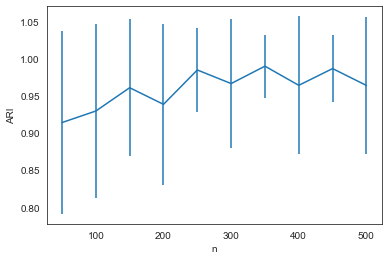

In [181]:
# plot clusterings wrt n

fig, ax = plt.subplots(1)
fig1 = plt.errorbar(sizes, score[:,0,0], yerr= score[:,0,1])
fig2 = plt.errorbar(sizes, score[:,1,0], yerr= score[:,1,1])
fig3 = plt.errorbar(sizes, score[:,2,0], yerr= score[:,2,1])
plt.legend((fig1, fig2, fig3), ("ICA","ASE","LSE"))
ax.set_xlabel("n"); ax.set_ylabel("ARI")

#stashfig("SBM-ICA-ASE-LSE-GMMk=6-ARIvN")

In [46]:
a = np.zeros(10)
for i in range(10):
    a[i] = np.mean(k_chosen[:,i])

Text(0, 0.5, 'dimension selected')

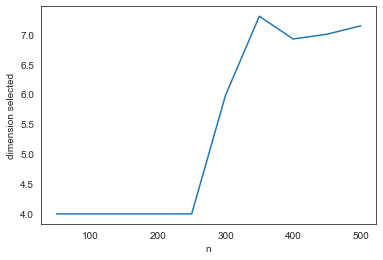

In [48]:
fig,ax = plt.subplots(1)
plt.plot(sizes, a)
ax.set_xlabel("n"); ax.set_ylabel("dimension selected")
